#YELP_Review_Classification_by_using_ML

In [1]:
!pip install contractions
!pip install unidecode
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=d32b7a2f922df216a2acd246c5f69d5fc0b1b629cab98cf1c4174df8448dc700
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [2]:
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import LancasterStemmer,PorterStemmer,SnowballStemmer,WordNetLemmatizer
from nltk.corpus import stopwords

from string import punctuation

import contractions # used for Contraction Mapping >> haven't => have not , isn't => is not
import unidecode # used for to Remove Accented Characters

from autocorrect import spell,Speller

import warnings
warnings.filterwarnings('ignore')

import time
import re

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

### Importing Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/YELP_Review_Classificataion_by_using_ML/yelp_review.csv')

In [5]:
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [6]:
df.shape

(5261668, 9)

In [7]:
df = df.loc[df.index <= 50000]

In [8]:
df.shape

(50001, 9)

In [9]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')

In [10]:
df.describe()

,stars,useful,funny,cool
count,50001.000000,50001.000000,50001.000000,50001.000000
mean,3.731565,1.514850,0.574809,0.691106
std,1.386125,3.521662,1.982707,2.469907
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,187.000000,59.000000,103.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50001 entries, 0 to 50000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    50001 non-null  object
 1   user_id      50001 non-null  object
 2   business_id  50001 non-null  object
 3   stars        50001 non-null  int64 
 4   date         50001 non-null  object
 5   text         50001 non-null  object
 6   useful       50001 non-null  int64 
 7   funny        50001 non-null  int64 
 8   cool         50001 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.8+ MB


In [12]:
df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

### Plot the Data

In [13]:
import seaborn as sns

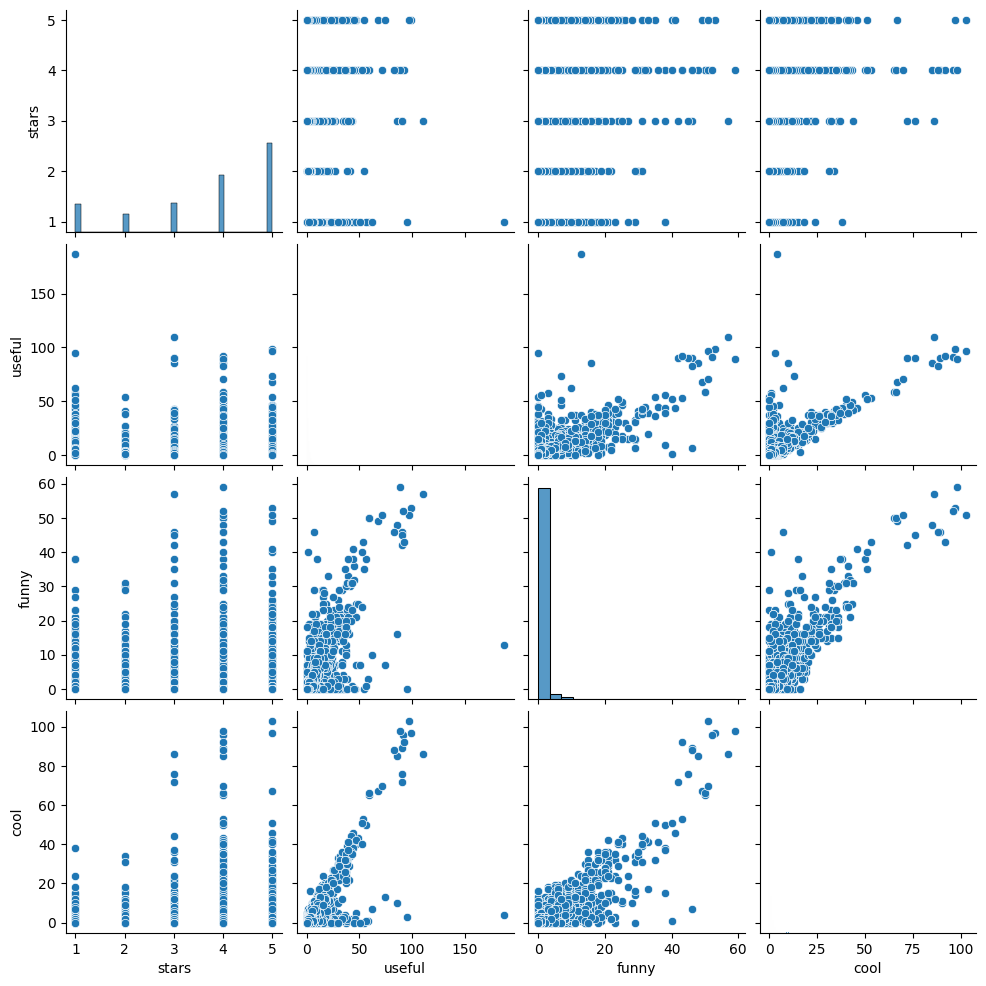

In [14]:
sns.pairplot(df)

<Axes: xlabel='stars', ylabel='Density'>

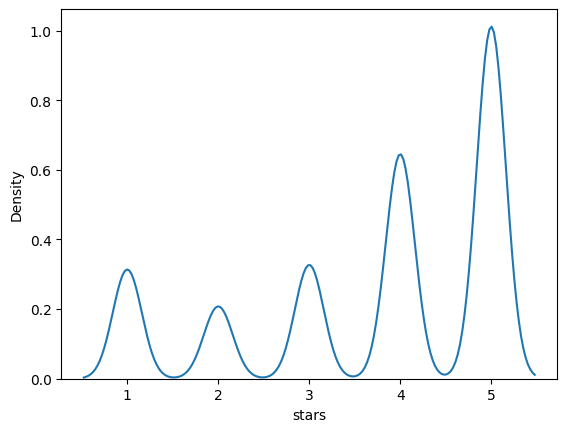

In [15]:
sns.kdeplot(df['stars'])

How many people gave 5 start rating

In [16]:
df['stars'].value_counts()

5    20188
4    12876
3     6527
1     6263
2     4147
Name: stars, dtype: int64

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Rating vs year')

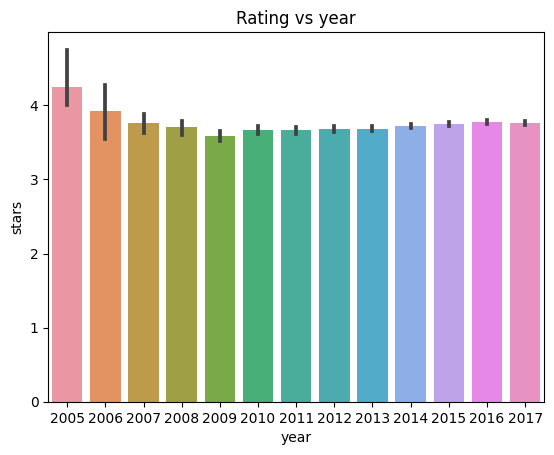

In [18]:
df['date']=pd.to_datetime(df['date']).dt.date
df.set_index('date').head(1)
df['year']=pd.to_datetime(df['date']).dt.year
sns.barplot(x=df['year'], y=df['stars'], data=df)
plt.title('Rating vs year')

Text(0.5, 1.0, 'Rating vs month')

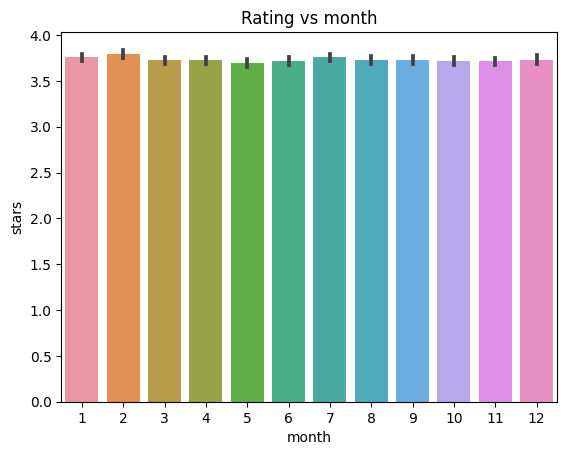

In [19]:
df['date']=pd.to_datetime(df['date']).dt.date
df.set_index('date').head(1)
df['month']=pd.to_datetime(df['date']).dt.month
sns.barplot(x=df['month'], y=df['stars'], data=df)
plt.title('Rating vs month')

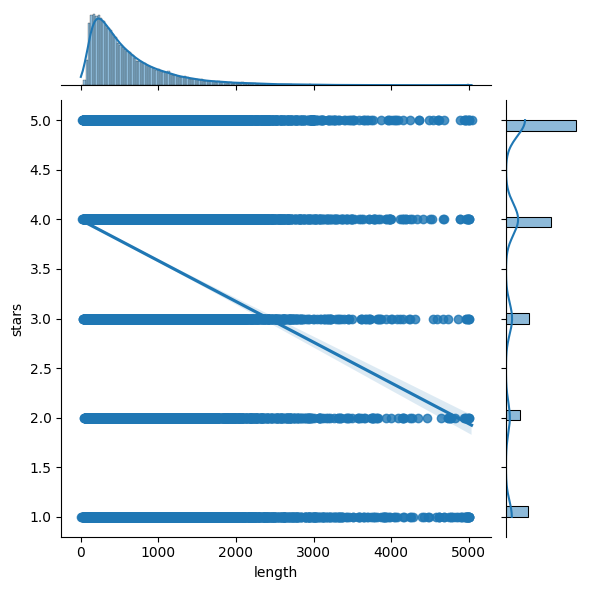

In [20]:
df['length'] = df['text'].apply(len)
sns.jointplot(x=df['length'],
              y=df['stars'],
              data=df,
              kind='reg')

It Looks like as lengthof text Increases the Rating is decreasing !! as per the graph

### Data Spliting

In [21]:
x_train,x_test,y_train,y_test=train_test_split(df.text, df.stars, test_size=0.25, random_state=42)

### Data Preprocessing

Now we will see below steps of implementation
1. remove newline tabs
2. remove whitespace
3. remove accented character
4. contraction mapping : haven't have not
5. cleaning punctuation stopwords
6. autocorrect
7. stemming and lemmatization

###### 1. remove newline tabs

In [22]:
def remove_newline(df):
    clean_text=df.replace("\\n","").replace("\n","").replace("\t","").replace("\\","")
    return clean_text

In [23]:
train_clean_text = x_train.apply(remove_newline)
test_clean_text = x_test.apply(remove_newline)

In [24]:
train_clean_text

13400    Amazing! From the food to the service to the a...
883      I am not sure how this place has so few rating...
7303     What a terrible experience.When my friend and ...
45125    I should say that I consider myself a foodie. ...
874      How can you not seriously love this place? For...
                               ...                        
11284    I'm normally a fan of Rachel's Kitchen, but to...
44732    We booked the limo service for our weekend tri...
38158    Love the meat  but everything else is super ex...
860      I realized when I was preparing to deploy over...
15795    LOVE Pink Box!!!! We had them cater a doughnut...
Name: text, Length: 37500, dtype: object

###### 2. remove whitespace

In [25]:
def remove_whitespace(data):
#     pattern=re.compile('\s+') # multiple whitespaces
#     without_whitespace=re.sub(pattern," ",data) # single whitespace
    without_whitespace=re.sub(r'\s+'," ",data) #multiple space removed with single space
    return without_whitespace

Syntax: re.sub(pattern, repl, string, count=0, flags=0)

Parameters: pattern – the pattern which is to be searched and substituted repl – the string with which the pattern is to be replaced string – the name of the variable in which the pattern is stored

In [26]:
train_clean_text=train_clean_text.apply(remove_whitespace)
test_clean_text=test_clean_text.apply(remove_whitespace)

In [27]:
train_clean_text

13400    Amazing! From the food to the service to the a...
883      I am not sure how this place has so few rating...
7303     What a terrible experience.When my friend and ...
45125    I should say that I consider myself a foodie. ...
874      How can you not seriously love this place? For...
                               ...                        
11284    I'm normally a fan of Rachel's Kitchen, but to...
44732    We booked the limo service for our weekend tri...
38158    Love the meat but everything else is super exp...
860      I realized when I was preparing to deploy over...
15795    LOVE Pink Box!!!! We had them cater a doughnut...
Name: text, Length: 37500, dtype: object

###### 3. Remove Accented Characters
What are the most common accents?
The most common accents are the acute (é), grave (è), circumflex (â, î or ô), tilde (ñ), umlaut and dieresis (ü or ï – the same symbol is used for two different purposes), and cedilla (ç).

In [28]:
def remove_accented_character(data):
    text=unidecode.unidecode(data)
    return text

In [29]:
train_clean_text=train_clean_text.apply(remove_accented_character)
test_clean_text=test_clean_text.apply(remove_accented_character)

In [30]:
train_clean_text

13400    Amazing! From the food to the service to the a...
883      I am not sure how this place has so few rating...
7303     What a terrible experience.When my friend and ...
45125    I should say that I consider myself a foodie. ...
874      How can you not seriously love this place? For...
                               ...                        
11284    I'm normally a fan of Rachel's Kitchen, but to...
44732    We booked the limo service for our weekend tri...
38158    Love the meat but everything else is super exp...
860      I realized when I was preparing to deploy over...
15795    LOVE Pink Box!!!! We had them cater a doughnut...
Name: text, Length: 37500, dtype: object

###### 4. Contraction Mapping
haven't => have not , isn't => is not

In [31]:
def contraction_mapping(data):
    tokens=data.split() # we required single words for contraction_mapping
    expanded_words=[]
    for word in tokens:
        expanded_words.append(contractions.fix(word))
    expanded_text=" ".join(expanded_words)
    return expanded_text

In [32]:
train_clean_text=train_clean_text.apply(contraction_mapping)
test_clean_text=test_clean_text.apply(contraction_mapping)

In [33]:
train_clean_text

13400    Amazing! From the food to the service to the a...
883      I am not sure how this place has so few rating...
7303     What a terrible experience.When my friend and ...
45125    I should say that I consider myself a foodie. ...
874      How can you not seriously love this place? For...
                               ...                        
11284    I am normally a fan of Rachel's Kitchen, but t...
44732    We booked the limo service for our weekend tri...
38158    Love the meat but everything else is super exp...
860      I realized when I was preparing to deploy over...
15795    LOVE Pink Box!!!! We had them cater a doughnut...
Name: text, Length: 37500, dtype: object

###### 5. Cleaning Punctuation Stopwords
first of all we need to remove neagtive words from stopwrds because in our data set main review is positive and negative

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
stop = stopwords.words('english')
stop.remove('no')
stop.remove('nor')
stop.remove('not')

def clean_data(text):
    tokens = RegexpTokenizer(r'\w+').tokenize(text) # '\w+' alphabetics words
    text_without_stop = [word for word in tokens if word not in stop]
    final_text = []
    for word in text_without_stop :
        if ((len(word)<2) or (word in punctuation)):
            pass
        else :
            final_text.append(word)
    text = " ".join(final_text)
    return text

In [36]:
train_clean_text=train_clean_text.apply(contraction_mapping)
test_clean_text=test_clean_text.apply(contraction_mapping)

In [37]:
train_clean_text

13400    Amazing! From the food to the service to the a...
883      I am not sure how this place has so few rating...
7303     What a terrible experience.When my friend and ...
45125    I should say that I consider myself a foodie. ...
874      How can you not seriously love this place? For...
                               ...                        
11284    I am normally a fan of Rachel's Kitchen, but t...
44732    We booked the limo service for our weekend tri...
38158    Love the meat but everything else is super exp...
860      I realized when I was preparing to deploy over...
15795    LOVE Pink Box!!!! We had them cater a doughnut...
Name: text, Length: 37500, dtype: object

###### 6. Autocorrect

In [38]:
def spelling_correction(data):
    spell=Speller(lang='en')
    correct_text=spell(data)
    return correct_text

In [39]:
# train_clean_text = train_clean_text.apply(spelling_correction)
# test_clean_text = test_clean_text.apply(spelling_correction)

In [40]:
# train_clean_text

###### 7. Stemming or Lemmatization

In [41]:
def lemmatization(data):
    tokens=word_tokenize(data)
    tokens=[word.lower() for word in tokens if word.isalpha()]
    lemma=WordNetLemmatizer()
    final_text=[]
    for i in tokens:
        lemmatized_word=lemma.lemmatize(i)
        final_text.append(lemmatized_word)
    return " ".join(final_text)

In [42]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [44]:
train_clean_text = train_clean_text.apply(lemmatization)
test_clean_text = test_clean_text.apply(lemmatization)

In [45]:
train_clean_text

13400    amazing from the food to the service to the am...
883      i am not sure how this place ha so few rating ...
7303     what a terrible my friend and i first arrived ...
45125    i should say that i consider myself a foodie i...
874      how can you not seriously love this place for ...
                               ...                        
11284    i am normally a fan of rachel kitchen but toni...
44732    we booked the limo service for our weekend tri...
38158    love the meat but everything else is super exp...
860      i realized when i wa preparing to deploy overs...
15795    love pink box we had them cater a doughnut bar...
Name: text, Length: 37500, dtype: object

### Word Embedding (Feature Engineering)

### 1. CountVectorizer

In [46]:
count=CountVectorizer(max_df=0.95,max_features=1000,lowercase=True)

In [47]:
count_val_train=count.fit_transform(train_clean_text)
count_val_test=count.transform(test_clean_text)

In [48]:
count_val_train

<37500x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2118650 stored elements in Compressed Sparse Row format>

In [49]:
count_val_train.A # convert/sparse matrix to array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
# Now we will see the above count vectorizer output in dataframe

pd.DataFrame(count_val_train.A, columns=count.get_feature_names_out())

,able,about,above,absolutely,across,actually,add,added,addition,after,...,year,yelp,yes,yet,you,young,your,yourself,yum,yummy
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
37498,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
len(count.get_feature_names_out())

1000

In [52]:
count.get_feature_names_out()

array(['able', 'about', 'above', 'absolutely', 'across', 'actually',
       'add', 'added', 'addition', 'after', 'afternoon', 'again', 'ago',
       'ahead', 'airport', 'all', 'almost', 'along', 'already', 'also',
       'although', 'always', 'am', 'amazing', 'ambiance', 'amount', 'an',
       'and', 'another', 'any', 'anyone', 'anything', 'anyway',
       'anywhere', 'appetizer', 'apple', 'appointment', 'appreciate',
       'are', 'area', 'around', 'arrived', 'asian', 'ask', 'asked',
       'asking', 'at', 'ate', 'atmosphere', 'attention', 'attentive',
       'attitude', 'authentic', 'available', 'average', 'avoid', 'away',
       'awesome', 'baby', 'back', 'bacon', 'bad', 'bag', 'baked', 'bar',
       'bartender', 'based', 'basically', 'bathroom', 'bbq', 'be', 'bean',
       'beat', 'beautiful', 'because', 'bed', 'beef', 'been', 'beer',
       'before', 'behind', 'being', 'believe', 'best', 'better',
       'between', 'beyond', 'big', 'bill', 'birthday', 'bit', 'bite',
       'black'

Drawabacks:

1. Course of dimentionality
2. Does not contain syntahtic meaning of words

### 2. TFIDF

In [53]:
tfidf = TfidfVectorizer(max_df=0.95,max_features=1000,lowercase=True)
tfidf_val_train = tfidf.fit_transform(train_clean_text)
tfidf_val_test = tfidf.transform(test_clean_text)

In [54]:
pd.DataFrame(tfidf_val_train.A,columns=tfidf.get_feature_names_out())

,able,about,above,absolutely,across,actually,add,added,addition,after,...,year,yelp,yes,yet,you,young,your,yourself,yum,yummy
0,0.000000,0.124666,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.134863,0.0,0.0,0.0
1,0.000000,0.036270,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.042366,...,0.0,0.0,0.0,0.06429,0.026090,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.063481,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.075601,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.088306,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.052078,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.374608,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0
37496,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0
37497,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.201936,0.0,0.000000,0.0,0.0,0.0
37498,0.069271,0.041297,0.0,0.0,0.0,0.063292,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.029706,0.0,0.000000,0.0,0.0,0.0


In [55]:
# Drawabacks:

# Course of dimentionality
# Does not contain syntahtic meaning of words

### With the help of CountVectorizer & TFIDF we will build the Naive Bayes Model

In [56]:
mnb_count = MultinomialNB()
mnb_count.fit(count_val_train.A,y_train)

pred_mnb_count = mnb_count.predict(count_val_test.A)

acc_count = accuracy_score(y_test,pred_mnb_count)
print('CountVectorizer Naive Bayes Accuracy = ',acc_count*100)

CountVectorizer Naive Bayes Accuracy =  57.187425005999515


In [57]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_val_train.A,y_train)

pred_mnb_tfidf = mnb_tfidf.predict(tfidf_val_test.A)

acc_tfidf = accuracy_score(y_test,pred_mnb_tfidf)
print('TFIDF Naive Bayes Accuracy = ',acc_count*100)

TFIDF Naive Bayes Accuracy =  57.187425005999515
